In [1]:
import glob
import numpy as np
import pylab as pl
import fitsio
import astropy.io.fits as fits

from astropy.table import Table, vstack, join
from desimodel.footprint import is_point_in_desi
from desimodel.focalplane.geometry import get_tile_radius_deg
from matplotlib.pyplot import figure
from desitarget.geomask import circles
from fiberassign.targets import (TARGET_TYPE_SKY, TARGET_TYPE_SAFE, desi_target_type, default_target_masks, default_survey_target_masks)

In [2]:
tpath = '/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-sv1.ecsv'

In [3]:
tiles = Table.read(tpath)
tiles

TILEID,CENTERID,PASS,RA,DEC,PROGRAM,IN_DESI,DESIGNHA,PRIORITY,STATUS,EBV_MED,DONEFRAC,AVAILABLE
,,,deg,deg,,,,,,,,
int32,int32,int32,float64,float64,str13,bool,float32,float64,str8,float32,float32,bool
80605,80605,8,36.448,-4.601,sv1_cmxlrgqso,False,0.00,2.000e-03,obsend,0.026,5.4000,False
80606,80606,7,36.448,-4.501,sv1_cmxelg,False,0.00,2.000e-03,obsend,0.026,4.1000,False
80607,80607,8,106.740,56.100,sv1_cmxlrgqso,True,0.00,2.000e-03,obsend,0.053,10.7000,True
80608,80608,7,106.740,56.200,sv1_cmxelg,True,0.00,2.000e-03,obsend,0.053,8.1000,True
80609,80609,8,150.120,2.206,sv1_cmxlrgqso,True,0.00,2.000e-03,obsend,0.023,4.0000,True
80610,80610,7,150.120,2.306,sv1_cmxelg,True,0.00,2.000e-03,obsend,0.022,5.1000,True
80611,80611,10,35.220,30.300,sv1bgsmws,False,0.00,2.000e+00,obsend,0.088,0.7500,False
80612,80612,10,66.680,-5.240,sv1bgsmws,False,0.00,2.000e-03,obsend,0.040,1.0500,False


In [4]:
np.unique(tiles['PROGRAM'].data)

array(['cmxm33', 'sv1_cmxelg', 'sv1_cmxlrgqso', 'sv1bgsmws', 'sv1elg',
       'sv1elgqso', 'sv1lrgqso', 'sv1lrgqso2', 'sv1m31'], dtype='<U13')

In [5]:
tiles = tiles[tiles['PROGRAM'] == 'sv1bgsmws']
tiles

TILEID,CENTERID,PASS,RA,DEC,PROGRAM,IN_DESI,DESIGNHA,PRIORITY,STATUS,EBV_MED,DONEFRAC,AVAILABLE
,,,deg,deg,,,,,,,,
int32,int32,int32,float64,float64,str13,bool,float32,float64,str8,float32,float32,bool
80611,80611,10,35.220,30.300,sv1bgsmws,False,0.00,2.000e+00,obsend,0.088,0.7500,False
80612,80612,10,66.680,-5.240,sv1bgsmws,False,0.00,2.000e-03,obsend,0.040,1.0500,False
80613,80613,10,106.740,56.100,sv1bgsmws,True,0.00,2.000e-03,obsend,0.053,1.0500,True
80614,80614,10,154.100,-1.375,sv1bgsmws,True,46.14,2.000e+00,obsend,0.044,0.5250,True
80616,80616,10,356.000,29.000,sv1bgsmws,False,0.00,2.000e+00,obsend,0.109,0.5500,False
80617,80617,10,5.000,28.000,sv1bgsmws,False,0.00,2.000e-03,obsend,0.036,1.0250,False
80618,80618,10,114.221,38.469,sv1bgsmws,True,0.00,2.000e-03,obsend,0.056,1.0750,True
80619,80619,10,144.000,65.000,sv1bgsmws,True,31.30,2.000e+00,obsend,0.073,0.8000,True


In [6]:
tiles[tiles['TILEID'].data == 80657]

TILEID,CENTERID,PASS,RA,DEC,PROGRAM,IN_DESI,DESIGNHA,PRIORITY,STATUS,EBV_MED,DONEFRAC,AVAILABLE
,,,deg,deg,,,,,,,,
int32,int32,int32,float64,float64,str13,bool,float32,float64,str8,float32,float32,bool
80657,80657,10,158.128,10.360,sv1bgsmws,True,55.02,2.000e+00,obsend,0.032,0.7500,True


In [7]:
tiles = Table.read('/global/cfs/cdirs/desi/spectro/redux/everest/tiles-everest.csv')
tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,str7,float64,int64,str6,str7
1,sv3,dark,sv3dark,3,2299.4,150.04,2.286,1409.3,1621.8,1423.6,1200.0,obsend,true,1621.8,1598.7,1535.4,dark,0.9,20210406,none,none
2,sv3,dark,sv3dark,2,1900.4,150.061,2.069,1411.1,1338.7,1366.6,1200.0,obsend,true,1338.7,1333.2,1351.2,dark,0.9,20210407,none,none
3,sv3,dark,sv3dark,1,951.5,150.212,2.226,1404.7,1435.2,1287.4,1200.0,obsend,true,1435.2,1365.9,1711.6,dark,0.9,20210409,none,none
4,sv3,dark,sv3dark,1,1065.1,149.98,2.171,1415.1,1460.5,1238.8,1200.0,obsend,true,1460.5,1381.4,1769.7,dark,0.9,20210410,none,none
5,sv3,dark,sv3dark,2,1656.9,150.187,2.099,1402.2,1398.0,1361.3,1200.0,obsend,true,1398.0,1408.8,1556.4,dark,0.9,20210412,none,none
6,sv3,dark,sv3dark,2,1668.3,150.106,2.302,1422.0,1517.2,1232.0,1200.0,obsend,true,1517.2,1441.7,1480.9,dark,0.9,20210417,none,none
7,sv3,dark,sv3dark,1,1750.8,149.993,2.237,1408.0,1385.1,1399.1,1200.0,obsend,true,1385.1,1409.8,1563.7,dark,0.9,20210429,none,none
8,sv3,dark,sv3dark,2,2347.9,150.128,2.065,1415.1,1661.7,1626.1,1200.0,obsend,true,1661.7,1696.9,1708.5,dark,0.9,20210430,none,none
9,sv3,dark,sv3dark,2,2457.8,150.17,2.28,1031.6,1345.2,1088.4,1200.0,obsend,true,1345.2,1292.8,1227.6,dark,0.9,20210502,none,none


In [8]:
np.unique(tiles['FAPRGRM'].data)

array(['backup', 'backup1', 'bgsmws', 'bright', 'dark', 'dc3r2',
       'dithfocus', 'dithlost', 'dithprec', 'elg', 'elgqso', 'lrgqso',
       'lrgqso2', 'm31', 'm33', 'mwclusgaldeep', 'praesepe', 'rosette',
       'scndcosmos', 'scndhetdex', 'ssv', 'umaii', 'unwisebluebright',
       'unwisebluefaint', 'unwisegreen'], dtype='<U16')

In [9]:
tiles = tiles[tiles['FAPRGRM'] == 'bgsmws']
tiles.sort('EFFTIME_GFA')
tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,str7,float64,int64,str6,str7
80665,sv1,bgsmws,sv1bgsmws,9,3593.9,198.0,7.0,0.0,1273.3,0.0,600.0,obsend,true,1308.3,1273.3,1077.9,bright,0.9,20210322,none,none
80660,sv1,bgsmws,sv1bgsmws,15,5614.1,168.382,50.4622,0.0,1676.4,0.0,600.0,obsend,true,1698.2,1676.4,1457.2,bright,0.9,20210131,none,none
80659,sv1,bgsmws,sv1bgsmws,15,9949.0,165.0,32.375,0.0,866.9,0.0,600.0,obsend,true,935.7,866.9,635.0,bright,0.9,20210304,none,none
80657,sv1,bgsmws,sv1bgsmws,7,5931.4,158.128,10.36,0.0,917.4,0.0,600.0,obsend,true,998.5,917.4,526.2,bright,0.9,20210331,none,none
80650,sv1,bgsmws,sv1bgsmws,22,8411.6,135.0,83.0,0.0,2329.6,0.0,600.0,obsend,true,2390.8,2329.6,1642.3,bright,0.9,20210322,none,none
80645,sv1,bgsmws,sv1bgsmws,13,3900.9,120.0,40.0,0.0,1942.3,0.0,600.0,obsend,true,2041.2,1942.3,1651.8,bright,0.9,20210205,none,none
80626,sv1,bgsmws,sv1bgsmws,2,600.1,23.4,25.6,0.0,113.0,116.2,600.0,obsstart,false,108.4,113.0,67.0,bright,0.9,20210203,none,none
80635,sv1,bgsmws,sv1bgsmws,5,1500.3,36.0,-7.0,0.0,187.4,180.8,600.0,obsstart,false,200.2,187.4,87.4,bright,0.9,20210105,none,none
80637,sv1,bgsmws,sv1bgsmws,5,3633.1,38.5,0.5,0.0,208.3,196.4,600.0,obsstart,false,245.9,208.3,83.1,bright,0.9,20210221,none,none


In [10]:
utids, cnts = np.unique(tiles['TILEID'].data, return_counts=True)

In [11]:
utids

array([80611, 80612, 80613, 80614, 80616, 80617, 80618, 80619, 80624,
       80626, 80627, 80628, 80629, 80632, 80633, 80635, 80636, 80637,
       80638, 80639, 80640, 80641, 80642, 80643, 80644, 80645, 80646,
       80647, 80648, 80649, 80650, 80651, 80652, 80653, 80654, 80655,
       80656, 80657, 80658, 80659, 80660, 80661, 80662, 80663, 80664,
       80665, 80666, 80740, 80741, 80742])

In [12]:
cnts.max()

1

In [13]:
len(utids)

50

In [14]:
np.count_nonzero(tiles['ZDONE'] == 'false')

15

In [15]:
np.count_nonzero(tiles['EFFTIME_SPEC'] < 600.)

13

In [16]:
np.count_nonzero(tiles['EFFTIME_GFA'] < 600.)

20

In [17]:
np.count_nonzero(tiles['OBSSTATUS'] == 'obsstart')

13

In [18]:
tiles = tiles[tiles['OBSSTATUS'] == 'obsend']
tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,str7,float64,int64,str6,str7
80665,sv1,bgsmws,sv1bgsmws,9,3593.9,198.0,7.0,0.0,1273.3,0.0,600.0,obsend,true,1308.3,1273.3,1077.9,bright,0.9,20210322,none,none
80660,sv1,bgsmws,sv1bgsmws,15,5614.1,168.382,50.4622,0.0,1676.4,0.0,600.0,obsend,true,1698.2,1676.4,1457.2,bright,0.9,20210131,none,none
80659,sv1,bgsmws,sv1bgsmws,15,9949.0,165.0,32.375,0.0,866.9,0.0,600.0,obsend,true,935.7,866.9,635.0,bright,0.9,20210304,none,none
80657,sv1,bgsmws,sv1bgsmws,7,5931.4,158.128,10.36,0.0,917.4,0.0,600.0,obsend,true,998.5,917.4,526.2,bright,0.9,20210331,none,none
80650,sv1,bgsmws,sv1bgsmws,22,8411.6,135.0,83.0,0.0,2329.6,0.0,600.0,obsend,true,2390.8,2329.6,1642.3,bright,0.9,20210322,none,none
80645,sv1,bgsmws,sv1bgsmws,13,3900.9,120.0,40.0,0.0,1942.3,0.0,600.0,obsend,true,2041.2,1942.3,1651.8,bright,0.9,20210205,none,none
80624,sv1,bgsmws,sv1bgsmws,11,3300.9,4.0,10.0,0.0,652.2,574.7,600.0,obsend,true,674.6,652.2,378.5,bright,0.9,20210109,none,none
80614,sv1,bgsmws,sv1bgsmws,12,3831.2,154.1,-1.375,0.0,622.2,649.2,600.0,obsend,true,670.4,622.2,377.5,bright,0.9,20210331,none,none
80611,sv1,bgsmws,sv1bgsmws,13,3620.9,35.22,30.3,0.0,688.2,687.8,600.0,obsend,true,742.3,688.2,439.3,bright,0.9,20201222,none,none


In [19]:
ntileobs = np.count_nonzero(tiles['OBSSTATUS'] == 'obsend')
ntileobs

37

In [20]:
trad = get_tile_radius_deg()
trad

1.6280324520485583

In [21]:
tarea = np.pi * trad**2.
tarea

8.326758859738527

In [22]:
# There is strictly a little overlap between SV1 tiles. 
sv1_area = tarea * ntileobs
sv1_area

308.0900778103255

In [23]:
# 40% chance of assignment in MINISV (true of restricted reach in SV1?)
308. * 0.40

123.2

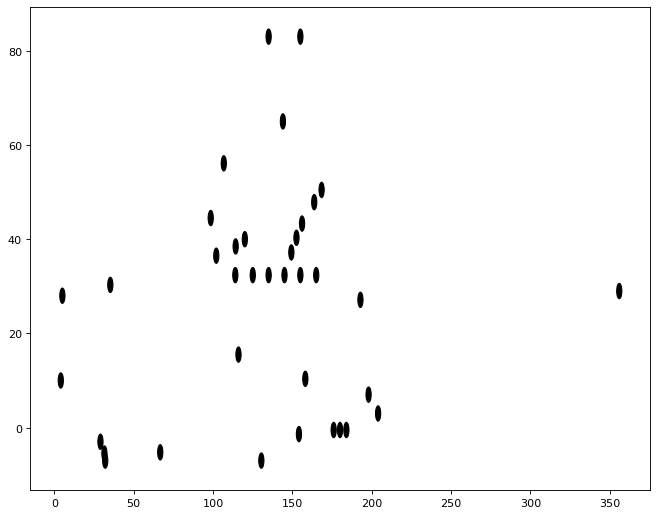

In [24]:
figure(figsize=(10, 8), dpi=80)

circles(tiles['TILERA'].data, tiles['TILEDEC'].data, s=1.628, c='k', vmin=None, vmax=None)

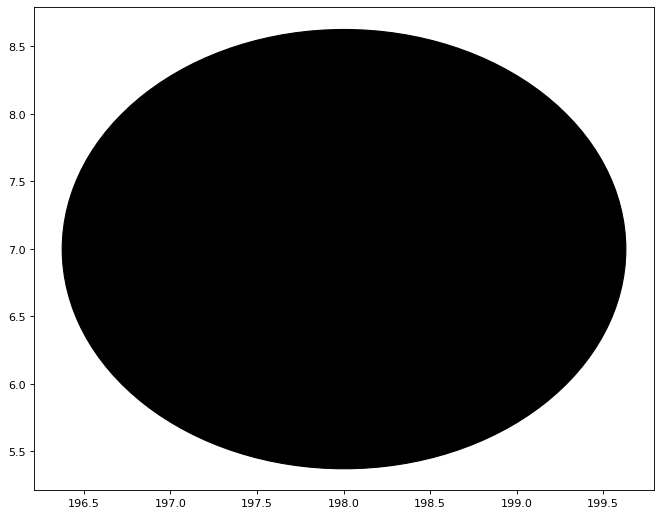

In [25]:
figure(figsize=(10, 8), dpi=80)

circles(tiles['TILERA'].data[0], tiles['TILEDEC'].data[0], s=1.628, c='k', vmin=None, vmax=None)

In [26]:
np.sort(tiles['EFFTIME_GFA'].data)

array([   0. ,    0. ,    0. ,    0. ,    0. ,    0. ,  574.7,  649.2,
        687.8,  717.9,  785.4,  839.6,  890.6,  997. , 1011.9, 1018.6,
       1041.1, 1196.7, 1266.5, 1269.2, 1347.3, 1357. , 1406.9, 1434.2,
       1467.6, 1471.5, 1574. , 1574.9, 1596. , 1608.1, 1663.6, 1726.1,
       1875.6, 1939.8, 2262.1, 2296.2, 2812.5])

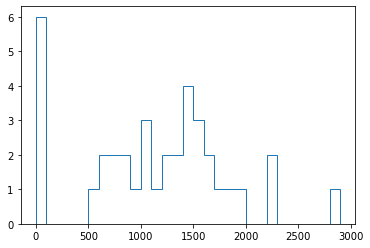

In [27]:
_ = pl.hist(tiles['EFFTIME_GFA'].data, bins=np.arange(0.0, 3000., 100.), histtype='step')

##  LSS SV1 randoms

See https://desi.lbl.gov/trac/wiki/SurveyValidation/SV1/LSScat

Long and short: SV1 random TARGETIDs were made up on the fly (such that there were repeats were tiles were non-overlapping).
To identify duplicates, we then use RA / TARGET_RA not TARGETID.  This is rough, but the best that can be done for the time being. 

In [28]:
tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,str7,float64,int64,str6,str7
80665,sv1,bgsmws,sv1bgsmws,9,3593.9,198.0,7.0,0.0,1273.3,0.0,600.0,obsend,true,1308.3,1273.3,1077.9,bright,0.9,20210322,none,none
80660,sv1,bgsmws,sv1bgsmws,15,5614.1,168.382,50.4622,0.0,1676.4,0.0,600.0,obsend,true,1698.2,1676.4,1457.2,bright,0.9,20210131,none,none
80659,sv1,bgsmws,sv1bgsmws,15,9949.0,165.0,32.375,0.0,866.9,0.0,600.0,obsend,true,935.7,866.9,635.0,bright,0.9,20210304,none,none
80657,sv1,bgsmws,sv1bgsmws,7,5931.4,158.128,10.36,0.0,917.4,0.0,600.0,obsend,true,998.5,917.4,526.2,bright,0.9,20210331,none,none
80650,sv1,bgsmws,sv1bgsmws,22,8411.6,135.0,83.0,0.0,2329.6,0.0,600.0,obsend,true,2390.8,2329.6,1642.3,bright,0.9,20210322,none,none
80645,sv1,bgsmws,sv1bgsmws,13,3900.9,120.0,40.0,0.0,1942.3,0.0,600.0,obsend,true,2041.2,1942.3,1651.8,bright,0.9,20210205,none,none
80624,sv1,bgsmws,sv1bgsmws,11,3300.9,4.0,10.0,0.0,652.2,574.7,600.0,obsend,true,674.6,652.2,378.5,bright,0.9,20210109,none,none
80614,sv1,bgsmws,sv1bgsmws,12,3831.2,154.1,-1.375,0.0,622.2,649.2,600.0,obsend,true,670.4,622.2,377.5,bright,0.9,20210331,none,none
80611,sv1,bgsmws,sv1bgsmws,13,3620.9,35.22,30.3,0.0,688.2,687.8,600.0,obsend,true,742.3,688.2,439.3,bright,0.9,20201222,none,none


In [29]:
fbas = glob.glob('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-*')
fbas = sorted(fbas)
fbas

['/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080605.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080606.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080607.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080608.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080609.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080610.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080611.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080612.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080613.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080614.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080616.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080617.fits',
 '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080618.fits',
 '/global/cfs/cdirs/desi/

In [30]:
keep = [fits.open(fba)[0].header['TILEID'] in tiles['TILEID'].data for fba in fbas]

In [31]:
np.mean(keep)

0.34579439252336447

In [32]:
fbas = np.array(fbas)[keep]

In [33]:
fbas

array(['/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080611.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080612.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080613.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080614.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080616.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080617.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080618.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080619.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080624.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080629.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080632.fits',
       '/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080633.fits',
       '/global/cfs/cdirs/de

In [34]:
len(fbas)

37

In [35]:
fba = fits.open(fbas[0])

In [36]:
fba.info()

Filename: /global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080611.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  FASSIGN       1 BinTableHDU     65   5020R x 14C   [J, K, J, J, E, I, J, 3A, D, D, K, B, E, E]   
  2  FTARGETS      1 BinTableHDU     53   12935R x 8C   [K, D, D, K, B, J, D, J]   
  3  FAVAIL        1 BinTableHDU     43   12935R x 3C   [J, J, K]   


In [37]:
nrow = 0

for i, fba in enumerate(fbas):
    fba = fits.open(fba)
    
    print('{:d}\t{:d}'.format(i, len(fba['FAVAIL'].data['TARGETID'])))
    
    nrow += len(fba['FAVAIL'].data['TARGETID'])
    
print()
print(nrow)

0	12935
1	12745
2	12896
3	12769
4	12781
5	12719
6	12816
7	12965
8	12790
9	12786
10	12646
11	13095
12	12872
13	12679
14	12753
15	12819
16	12696
17	12720
18	12793
19	12744
20	12808
21	13053
22	12556
23	12888
24	12744
25	12762
26	12841
27	12675
28	12950
29	12864
30	12710
31	12770
32	12991
33	12937
34	12931
35	12867
36	12580

473946


In [38]:
37 * 12991 / 2500.

192.2668

In [39]:
sciencemask, stdmask, skymask, suppskymask, safemask, excludemask = \
                default_survey_target_masks('sv1')

In [40]:
sfbas = []

for fba in fbas:
   # /global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/random0/fba-080642.fits
   tileid     = fba.split('/')[-1].split('-')[-1].replace('.fits','')
    
   x          = Table(fits.open(fba)['FAVAIL'].data) 
   x['TILEID']= np.int(tileid) 

   y          = Table(fits.open(fba)['FTARGETS'].data)

   x          = join(x, y['TARGETID', 'TARGET_RA', 'TARGET_DEC'], join_type='left', keys='TARGETID') 

   z          = Table(fits.open(fba)['FASSIGN'].data)['LOCATION', 'FIBERSTATUS']

   keeplocs   = z['FIBERSTATUS'].data == 0
   z          = z['LOCATION'].data[keeplocs]

   x          = x[np.isin(x['LOCATION'].data, z)]

   sfbas.append(x)

sfbas = vstack(sfbas)
sfbas

LOCATION,FIBER,TARGETID,TILEID,TARGET_RA,TARGET_DEC
int32,int32,int64,int64,float64,float64
6484,3078,0,80611,36.12240363249487,31.686513791782197
6483,3087,6,80611,36.09386490566186,31.720289540184925
6485,3470,10,80611,36.16870419175712,31.650274022341765
6486,3491,16,80611,36.19044462206948,31.632625616245143
6503,3466,18,80611,36.22160922411851,31.632294894452723
6503,3466,21,80611,36.225828567627154,31.637137170216384
6503,3466,22,80611,36.223382642824234,31.620836470753222
6503,3466,23,80611,36.23157644057259,31.63582175042567
6503,3466,26,80611,36.23650893611502,31.62923547536745


In [41]:
len(np.unique(sfbas['TILEID'].data))

37

In [42]:
type(sfbas['TARGETID'].data[0])

numpy.int64

In [43]:
urandid, cnts = np.unique(sfbas['TARGET_RA'].data, return_counts=True)

In [44]:
cnts.max()

2

In [45]:
len(urandid) / 2500.

188.0232

In [59]:
sv1_area, 188.0232 / sv1_area

(308.0900778103255, 0.6102864504314085)

Pointed at area was ~300 sq. deg.  Of this, the filling factor reachable by a working fiber was
61% on average. 

In [46]:
uids, idx = np.unique(sfbas['TARGET_RA'].data, return_index=True)

In [47]:
idx

array([104308, 104310, 104309, ...,  63093,  63090,  63102])

In [48]:
dup = np.arange(len(sfbas))
dup = dup[~np.isin(dup, idx)]

In [49]:
len(dup), len(sfbas) - len(idx), len(sfbas)

(2224, 2224, 472282)

In [50]:
dup = sfbas[dup]
dup

LOCATION,FIBER,TARGETID,TILEID,TARGET_RA,TARGET_DEC
int32,int32,int64,int64,float64,float64
3399,1633,4456,80633,30.537703960166905,-6.789032504984182
3336,1776,4498,80633,30.624340631190137,-6.838312367735155
3378,1634,4509,80633,30.568892224761182,-6.8009056157664345
3337,1797,4526,80633,30.6466558821172,-6.789279485583899
3337,1797,4528,80633,30.64936967864784,-6.7951703861074435
3357,1752,4529,80633,30.60501557069821,-6.794490530161834
3445,1631,4576,80633,30.50308267378299,-6.736464781511357
3422,1608,4584,80633,30.50340340136233,-6.75859491128909
3484,1603,4596,80633,30.44146498153994,-6.6910453326854205


In [51]:
100. * len(dup) / len(sfbas)

0.47090509483740645

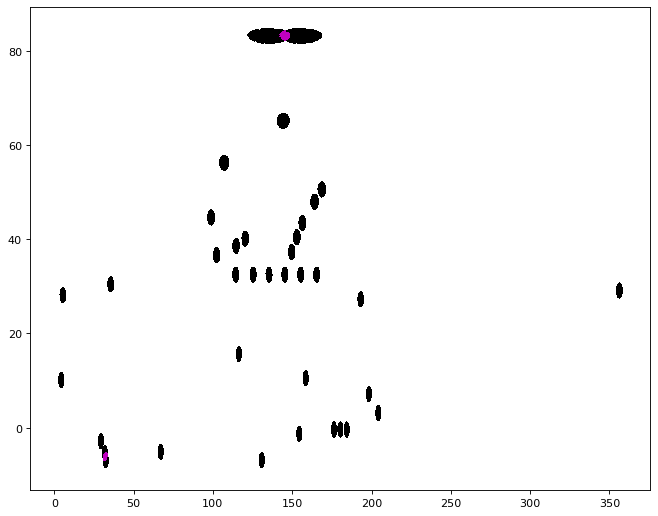

In [52]:
figure(figsize=(10, 8), dpi=80)

pl.plot(sfbas['TARGET_RA'].data, sfbas['TARGET_DEC'].data, marker=',', lw=0.0, c='k')
pl.plot(  dup['TARGET_RA'].data,   dup['TARGET_DEC'].data, marker=',', lw=0.0, c='m')

Randoms reachable by overlapping tiles shown in magenta.

Trace the origin of the randoms from desitarget (lesson learnt: RA, DEC were propagated, TARGETID was not).

In [53]:
cols    = ['TARGETID', 'RA', 'DEC']

# rpath = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits' 
rpath   = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/randoms/resolve/randoms-1-0.fits'

trand   = fitsio.read(rpath, columns=cols)

In [54]:
trand

array([( 14.21420797,  26.9738401 , 327858790596611025),
       (335.46815173,   1.58205713, 327858202743932676),
       (344.72384811,  12.90292027, 327858478238403673), ...,
       (140.74193686,   1.55624497, 327858199476569330),
       ( 53.75762932, -11.70432048, 327857879702832270),
       (124.541903  ,  67.41455486, 327863843420111770)],
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('TARGETID', '>i8')])

In [55]:
in_dtarget = np.isin(sfbas['TARGET_RA'].data, trand['RA'].data)

In [56]:
np.mean(in_dtarget)

1.0

# Done.